# Сервис для статистического анализа потока посетителей.
## Пол, возраст и интенсивность посещений.

In [1]:
import models
import cv2
import os

fdet = models.FaceDetection()
fdes = models.FaceDescription('data/model_weights/LandmarkFace.dat', 'data/model_weights/ResNetFace.dat')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Нахождение и распознавание лиц.
## Благодоря технологиям верифекации человека по лицу наш сервис всегда знает, кто когда зашел и ушел, а так же сколько человек сейчас находится в помещении.
### Пример "Face Detection".
<img src="data/images/facedetect.png" width="50%">

In [2]:
# cap = cv2.VideoCapture(0)

# facesV = []

# while True:

#     ret, frame = cap.read()

#     dets = fdet(frame)
    
#     facesV = fdes(frame, dets = dets)
    
#     for k, d in enumerate(dets):
#         cv2.rectangle(frame, (d.left(), d.top()), (d.right(), d.bottom()), (0, 0, 255), 1, 8, 0)

#     cv2.imshow('capture', frame)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cv2.destroyAllWindows()
# cap.release()

# Описание лиц 128-мерным вектором.
## После нахождения лиц на изображении нейронная сеть типа ResNet-34 раскладывает его на 128-мерный вектор. После мы можем их сравнивать на схожесть. 

### Пример "Face Description".
<img src="data/images/facesPlot.png" width="50%">

In [3]:
# %matplotlib inline

# import matplotlib.pyplot as plt
# plt.figure(figsize = (20,10), dpi = 400)

# for i,face in enumerate(facesV):
#     plt.plot(face + i, label = 'Face_' + str(i))
# plt.legend()
# plt.xticks([])
# plt.yticks([])

# plt.show()

In [4]:
AGS_model = models.WideResNetCreater()()
AGS_model.load_weights(os.path.join("data/model_weights/", "weights.18-4.06.hdf5"))

/Users/nativesmell/Documents/Work/Hack_university/models.py:229: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=16, strides=(1, 1), padding="same", kernel_initializer="he_normal", kernel_regularizer=<keras.reg..., use_bias=False)`
  bias=self._use_bias)(inputs)
/Users/nativesmell/Documents/Work/Hack_university/models.py:177: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), strides=(1, 1), padding="same", kernel_initializer="he_normal", kernel_regularizer=<keras.reg..., use_bias=False)`
  bias=self._use_bias)(convs)
/Users/nativesmell/Documents/Work/Hack_university/models.py:188: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), strides=(1, 1), padding="same", kernel_initializer="he_normal", kernel_regularizer=<keras.reg..., use_bias=False)`
  bias=self._use_bias)(convs)
/Users/nativesmell/Documents/Work/Hack_university/models.py:196: UserWarning: Update your `Conv2D` call to the

In [5]:
from IPython.display import Image, display, SVG

fig = SVG(models.visModel(AGS_model, savePath = 'data/images/', name = 'AGS_structure'))

# Классификация по полу и оценка возраста
## Для классификации пола и  оценки возраста также используется сеть типа ResNet, но в этот раз мы имеем два выхода, один бинарный, он говорит мужчина перед нами или женщина, а второй выдает вектор, сумма координат которого даст оценку возраста.
### Структура модели.
<img src="data/images/AGS_structure.png" width="100%">

In [6]:
IRAM = models.IntensRecModelCreater()()
fig = SVG(models.visModel(IRAM, savePath = 'data/images/', name = 'IRAM_structure'))

# Для анализа временных последовательностей мы используем рекуррентные нейронные сети
## Они позволяют нам предсказывать следующие во времени события
### Пример рекуррентной сети

<img src="data/images/IRAM_structure.png" width="30%">

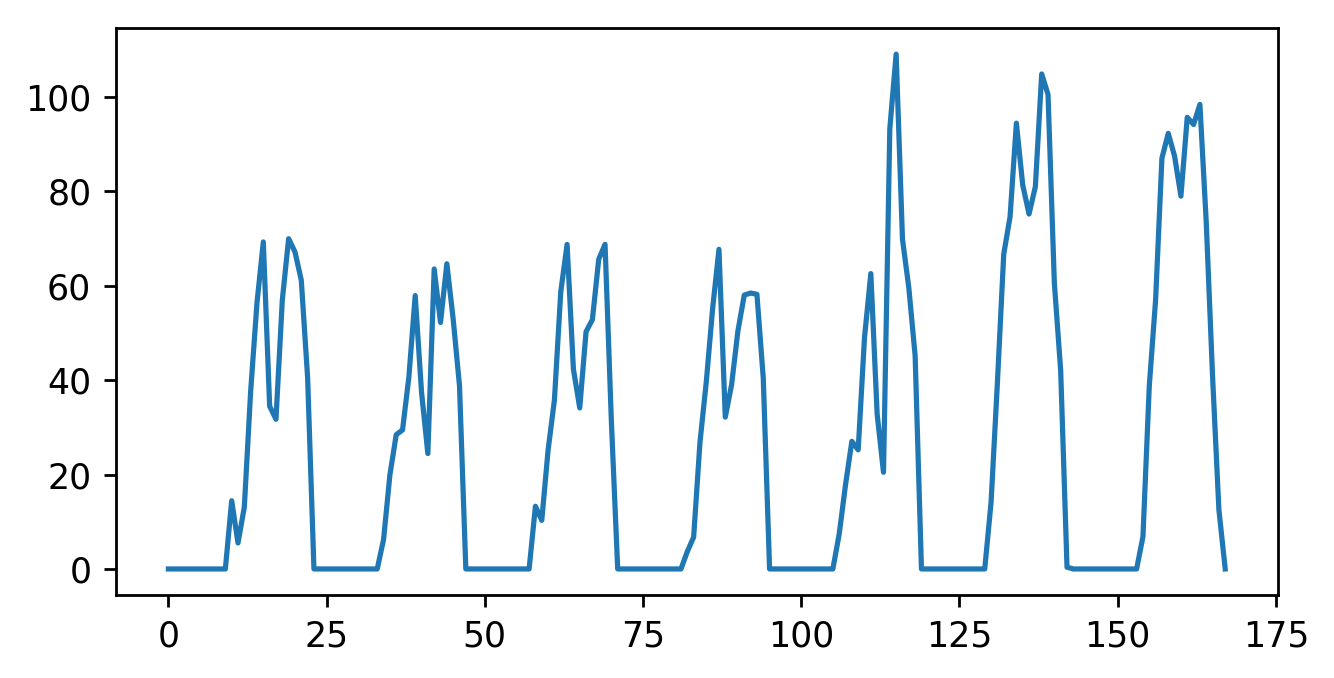

In [7]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

max_customers = 100


                   #0 1 2 3 4 5 6 7 8 9  10  11  12  13    14  15 16  17   18  19  20  21 22   23
weekEnd = np.array([0,0,0,0,0,0,0,0,0,0,0.1,0.4,0.6, 0.8, 0.9, 0.9, 0.8, 0.9, 1,1,0.7,0.4, 0.1, 0])
friDay = np.array([0,0,0,0,0,0,0,0,0,0,0.1,0.1,0.2, 0.3, 0.5, 0.6, 0.35, 0.3, 1,1,0.7,0.6, 0.5, 0])
weekDay = np.array([0,0,0,0,0,0,0,0,0,0,0.1,0.1,0.2, 0.3, 0.5, 0.6, 0.35, 0.3, 0.6,0.6,0.6,0.6, 0.4, 0])

data_set = np.array([])
for week in range(0,12):
    for days in range(0,4):

        for day in range(0,4):
            data_set = np.append(data_set, weekDay * max_customers + np.array([np.random.uniform(-10,10) if i != 0 else 0 for i in weekDay]))
            
        data_set = np.append(data_set, friDay * max_customers + np.array([np.random.uniform(-10,10) if i != 0 else 0 for i in friDay]))

        for day in range(0,2):
            data_set = np.append(data_set, weekEnd * max_customers + np.array([np.random.uniform(-10,10) if i != 0 else 0 for i in weekEnd]))

    
plt.figure(figsize = (6,3), dpi = 250)

plt.plot(data_set[:24*7])

plt.show()

In [9]:
X, Y = models.pad_sequences(data_set)

print(X[0],Y[0])

[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [14.44947021]
 [ 5.4994024 ]
 [13.12359052]
 [37.68205331]
 [56.41308374]
 [69.28229815]
 [34.48489069]
 [31.71186243]
 [56.96066901]
 [69.95768641]
 [67.17112175]
 [61.16177121]
 [40.55481304]
 [ 0.        ]] 0.0
